**[Google Colab Link](https://colab.research.google.com/drive/1mvxrpLY87A_2ZRLrLkOsStWDpsCfRRZh?usp=sharing)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# !rm -r '/content/csvs'
!unzip -q /content/drive/MyDrive/dataset/csvs.zip

[datagen.py file](https://drive.google.com/file/d/1oe6ou94stmeOYq-3iCrgahmzeLBBpVln/view?usp=sharing)
 and this notebook are in the same directory

---



In [ ]:
# !rm -r '/content/data'
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/')
from datagen import csv2img, get_datagenerator

df = csv2img('/content/csvs')

--> icml_face_data_1.csv
--> icml_face_data_2.csv
--> icml_face_data_3.csv
--> icml_face_data_4.csv
--> icml_face_data_5.csv
--> icml_face_data_6.csv



Training Data size: 28709
Validation Data size: 3589
Test Data size: 3589


In [ ]:
df.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.iloc[0:,1]

0           Training
1           Training
2           Training
3           Training
4           Training
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name: usage, Length: 35887, dtype: object

In [ ]:
EPOCHS = 150
BS = 128
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
pf = None

train_generator  = get_datagenerator('/content/data/train',preprocessing_func=pf, aug=True)
val_generator    = get_datagenerator('/content/data/test-public',preprocessing_func=pf)
test_generator  = get_datagenerator('/content/data/test-private',preprocessing_func=pf)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

# checkpoint
cp_filepath='/content/drive/MyDrive/fer/cps/baseline-weights-best.hdf5'
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [rlrop,checkpoint]

In [ ]:
history = model.fit(
  train_generator,
  validation_data = val_generator, 
  steps_per_epoch=28709// BS,
  validation_steps=3589 // BS,
  shuffle=True,
  epochs=EPOCHS,
  callbacks=callbacks_list,
  use_multiprocessing=False,
) 

Epoch 1/150
224/224 [==============================] - 21s 90ms/step - loss: 1.9216 - accuracy: 0.2580 - val_loss: 1.9147 - val_accuracy: 0.2595

Epoch 00001: val_accuracy improved from -inf to 0.25955, saving model to /content/drive/MyDrive/fer/cps/baseline-weights-best.hdf5
Epoch 2/150
224/224 [==============================] - 20s 88ms/step - loss: 1.5694 - accuracy: 0.3930 - val_loss: 1.4745 - val_accuracy: 0.4201

Epoch 00002: val_accuracy improved from 0.25955 to 0.42014, saving model to /content/drive/MyDrive/fer/cps/baseline-weights-best.hdf5
Epoch 3/150
224/224 [==============================] - 20s 88ms/step - loss: 1.4299 - accuracy: 0.4494 - val_loss: 1.4114 - val_accuracy: 0.4604

Epoch 00003: val_accuracy improved from 0.42014 to 0.46036, saving model to /content/drive/MyDrive/fer/cps/baseline-weights-best.hdf5
Epoch 4/150
224/224 [==============================] - 19s 87ms/step - loss: 1.3390 - accuracy: 0.4839 - val_loss: 1.2929 - val_accuracy: 0.4968

Epoch 00004: val_

In [ ]:
print('\n# Evaluate on validation data')
results_val = model.evaluate(val_generator)
print('val loss, val_accuracy:', results_val)


# Evaluate on validation data
29/29 [==============================] - 1s 28ms/step - loss: 1.0346 - accuracy: 0.6358
val loss, val_accuracy: [1.0345531702041626, 0.6358317136764526]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate(test_generator)
print('test loss, test accuracy:', results_test)


# Evaluate on test data
29/29 [==============================] - 1s 29ms/step - loss: 0.9813 - accuracy: 0.6503
test loss, test accuracy: [0.9812926054000854, 0.6503204107284546]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


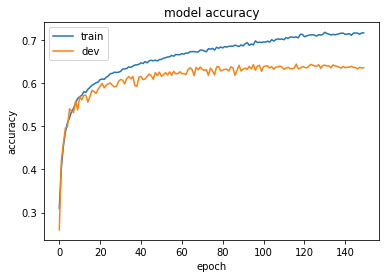

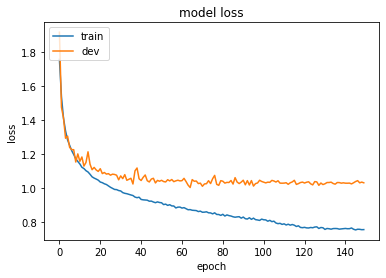

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/MyDrive/fer/saved_model/' + 'baseline' + epoch_str + test_acc + '.h5')

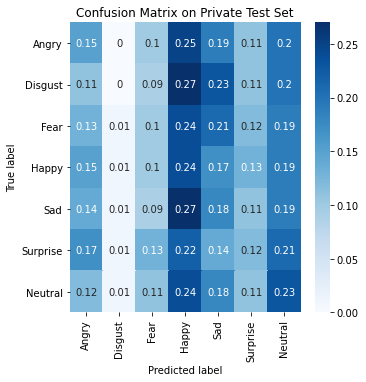

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict(val_generator).argmax(axis=1)
y_true = val_generator.classes

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(f'tensorflow {tf.__version__}')
print(f'keras {keras.__version__}')
!python --version

tensorflow 2.4.1
keras 2.4.0
Python 3.7.10
